In this notebook we demonstrate how we can leverage BERT to perform NER on conll2003 dataset.<br>
This notebook requires a GPU to get setup. We suggest you to run this on your local machine only if you have a GPU setup or else you can use google colab.

In [ ]:
#Installing required packages
#ตรวจสอบว่ากำลังใช้ Google Colab หรือไม่ หากไม่ใช้จะพิมพ์ว่า "Not Using Colab"
try :
    from google.colab import files #ลองนำเข้า google.colab เพื่อดูว่ารันอยู่บน Colab หรือไม่
    %tensorflow_version 2.x #เปิดใช้งาน TensorFlow หากอยู่ใน Colab

except ModuleNotFoundError :
    Print("Not Using Colab") #ถ้าไม่อยู่ใน Colab จะแสดงข้อความว่า "Not Using Colab"

#ติดตั้งแพ็กเกจ pytorch-pretrained-bert สำหรับใช้งาน BERT และ seqeval สำหรับคำนวณค่า f1_score
!pip install pytorch-pretrained-bert==0.4.0 #ติดตั้ง BERT สำหรับ PyTorch
!pip install seqeval==0.0.12 #ติดตั้ง seqeval สำหรับคำนวณ f1_score

#importing packages for string processing,dataframe handling, array manipulations, etc
import string
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

import warnings
warnings.filterwarnings("ignore")

#importing all the pytorch packages
import torch #แพ็กเกจหลักสำหรับ PyTorch
from torch.optim import Adam #ตัว optimizer Adam สำหรับการปรับพารามิเตอร์ของโมเดล
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#ใช้ในการจัดการกับชุดข้อมูลและการโหลดข้อมูลในรูปแบบ batch
from pytorch_pretrained_bert import BertTokenizer, BertConfig #สำหรับ tokenizer และ configuration ของ BERT
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam #สำหรับสร้างโมเดล BERT แบบ token classification และ optimizer ของ BERT

#importing additonal packages to aid preprocessing of data
from keras.preprocessing.sequence import pad_sequences #ใช้เติม sequence ของ token ให้มีขนาดเท่ากัน
from sklearn.model_selection import train_test_split #ใช้แบ่งข้อมูลออกเป็นชุดฝึกและชุดทดสอบ

#importing packages to calculate the f1_score of our model
from seqeval.metrics import f1_score #ใช้คำนวณ f1_score สำหรับประเมินประสิทธิภาพโมเดล



Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-0.0.12-py3-none-any.whl size=7416 sha256=69b94bbe4fa707d9c59f945752795e277fc64410a2c51cd1ae06a8fffb529631
  Stored in directory: /root/.cache/pip/wheels/6c/6c/fc/7076d687ba54f32c7be7eaaded97df359ef3c8fee08a2d4efc
Successfully built seqeval
Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [ ]:
#uploading data into google colab
#upload the test.txt and train.txt files respectively
try:
    from google.colab import files  #ลองนำเข้าโมดูล files จาก google.colab เพื่อใช้งานฟังก์ชันการอัปโหลดไฟล์
    uploaded = files.upload()       #เปิดหน้าต่างเพื่อให้อัปโหลดไฟล์ไปยัง Google Colab และเก็บไฟล์ไว้ในตัวแปร 'uploaded'

except ModuleNotFoundError:
    print("Not using Colab")        #หากไม่สามารถนำเข้าโมดูล google.colab ได้ จะแสดงข้อความว่า "Not using Colab"


Saving test.txt to test.txt
Saving train.txt to train.txt
Saving valid.txt to valid.txt


In [ ]:
"""
Load the training/testing data.
input: conll format data, but with only 2 tab separated colums - words and NEtags.
output: A list where each item is 2 lists.  sentence as a list of tokens, NER tags as a list for each token.
"""
#functions for preparing the data in the *.txt files
#ฟังก์ชันใช้โหลดข้อมูลจากไฟล์ .txt ที่อยู่ในรูปแบบ CoNLL (ข้อมูลแยกคำ (tokens) และแท็ก (tags) ออกจากกันด้วยแท็บ)) และคืนค่าลิสต์ของคำและแท็ก
def load__data_conll(file_path):
    myoutput, words, tags = [], [], []   #กำหนดให้ 'myoutput' เป็นลิสต์หลักที่เก็บลิสต์ย่อยของคำและแท็ก, 'words' เก็บคำแต่ละคำในประโยค, 'tags' เก็บแท็กของคำในประโยค
    fh = open(file_path)                 #เปิดไฟล์ที่ตำแหน่ง 'file_path' เพื่ออ่านข้อมูล
    for line in fh:                      #วนลูปเพื่ออ่านแต่ละบรรทัดจากไฟล์
        line = line.strip()              #ตัดช่องว่าง (whitespace) ด้านหน้าและหลังของบรรทัด
        if "\t" not in line:             #ถ้าไม่มีแท็บในบรรทัดนั้น (แสดงว่าจบประโยคแล้ว)
            #Sentence ended.
            myoutput.append([words, tags])  #เพิ่มลิสต์ [words, tags] ลงใน 'myoutput' (แสดงว่าจบประโยคหนึ่งแล้ว)
            words, tags = [], []            #เริ่มเก็บคำและแท็กใหม่สำหรับประโยคถัดไป
        else:
            word, tag = line.split("\t")    #แยกคำและแท็กออกจากกันโดยการใช้แท็บเป็นตัวแบ่ง
            words.append(word)              #เพิ่มคำลงในลิสต์ 'words'
            tags.append(tag)                #เพิ่มแท็กที่สอดคล้องกับคำนั้นลงในลิสต์ 'tags'
    fh.close()                              #ปิดไฟล์เมื่ออ่านข้อมูลเสร็จสิ้น
    return myoutput                         #คืนค่า 'myoutput' ซึ่งเป็นลิสต์ที่เก็บลิสต์ของคำและแท็กสำหรับแต่ละประโยค
#ผลลัพธ์ที่ได้จากฟังก์ชันคือ ลิสต์ที่ภายในประกอบด้วยลิสต์ย่อย 2 ลิสต์ (คำ และแท็ก) สำหรับแต่ละประโยคในไฟล์

"""
Get features for all words in the sentence
Features:
- word context: a window of 2 words on either side of the current word, and current word.
- POS context: a window of 2 POS tags on either side of the current word, and current tag.
input: sentence as a list of tokens.
output: list of dictionaries. each dict represents features for that word.
"""
#ฟังก์ชันใช้สร้างฟีเจอร์สำหรับแต่ละคำในประโยค โดยใช้คำที่อยู่ข้างหน้าและข้างหลังเพื่อให้ข้อมูลบริบท
def sent2feats(sentence):
    feats = [] # ลิสต์ที่จะเก็บฟีเจอร์ของแต่ละคำในประโยค
    sen_tags = pos_tag(sentence) # ใช้ฟังก์ชัน pos_tag เพื่อหาป้ายกำกับ POS ของแต่ละคำในประโยค
    for i in range(0,len(sentence)): # วนลูปผ่านแต่ละคำในประโยค
        word = sentence[i] # กำหนดคำปัจจุบัน
        wordfeats = {} # ดิกชันนารีที่จะเก็บฟีเจอร์ของคำปัจจุบัน
       #word features: word, prev 2 words, next 2 words in the sentence.
       #ฟีเจอร์ของคำ: คำปัจจุบัน, คำก่อนหน้า 2 คำ, คำถัดไป 2 คำ
        wordfeats['word'] = word # เก็บคำปัจจุบัน
        if i == 0:
            wordfeats["prevWord"] = wordfeats["prevSecondWord"] = "<S>" # กรณีเป็นคำแรกของประโยค
        elif i==1:
            wordfeats["prevWord"] = sentence[0] # กรณีเป็นคำที่สอง
            wordfeats["prevSecondWord"] = "</S>"
        else:
            wordfeats["prevWord"] = sentence[i-1] # เก็บคำก่อนหน้า 1 คำ
            wordfeats["prevSecondWord"] = sentence[i-2] # เก็บคำก่อนหน้า 2 คำ
        #next two words as features
        #คำถัดไป 2 คำเป็นฟีเจอร์
        if i == len(sentence)-2:
            wordfeats["nextWord"] = sentence[i+1] # กรณีคำก่อนหน้าสุดท้ายของประโยค
            wordfeats["nextNextWord"] = "</S>"
        elif i==len(sentence)-1:
            wordfeats["nextWord"] = "</S>" # กรณีคำสุดท้ายของประโยค
            wordfeats["nextNextWord"] = "</S>"
        else:
            wordfeats["nextWord"] = sentence[i+1] # เก็บคำถัดไป 1 คำ
            wordfeats["nextNextWord"] = sentence[i+2] # เก็บคำถัดไป 2 คำ

        #POS tag features: current tag, previous and next 2 tags.
        #ฟีเจอร์ของ POS: แท็ก POS ปัจจุบัน, แท็ก POS ก่อนหน้า 2 แท็ก และแท็ก POS ถัดไป 2 แท็ก
        wordfeats['tag'] = sen_tags[i][1] # เก็บแท็ก POS ปัจจุบัน
        if i == 0:
            wordfeats["prevTag"] = wordfeats["prevSecondTag"] = "<S>" # กรณีเป็นคำแรกของประโยค
        elif i == 1:
            wordfeats["prevTag"] = sen_tags[0][1] # กรณีเป็นคำที่สอง
            wordfeats["prevSecondTag"] = "</S>"
        else:
            wordfeats["prevTag"] = sen_tags[i - 1][1] # เก็บแท็ก POS ก่อนหน้า 1 แท็ก
            wordfeats["prevSecondTag"] = sen_tags[i - 2][1] # เก็บแท็ก POS ก่อนหน้า 2 แท็ก

            # next two words as features
            # แท็ก POS ถัดไป 2 แท็ก
        if i == len(sentence) - 2:
            wordfeats["nextTag"] = sen_tags[i + 1][1] # กรณีคำก่อนหน้าสุดท้ายของประโยค
            wordfeats["nextNextTag"] = "</S>"
        elif i == len(sentence) - 1:
            wordfeats["nextTag"] = "</S>" # กรณีคำสุดท้ายของประโยค
            wordfeats["nextNextTag"] = "</S>"
        else:
            wordfeats["nextTag"] = sen_tags[i + 1][1] # เก็บแท็ก POS ถัดไป 1 แท็ก
            wordfeats["nextNextTag"] = sen_tags[i + 2][1] # เก็บแท็ก POS ถัดไป 2 แท็ก
        #That is it! You can add whatever you want!
        # เพิ่มฟีเจอร์ของคำนี้เข้าไปในลิสต์
        feats.append(wordfeats)
    return feats # คืนค่าลิสต์ของฟีเจอร์สำหรับแต่ละคำในประโยค


In [ ]:
#preprocess the data by calling the functions
#โหลดข้อมูลการฝึกและทดสอบจากไฟล์ .txt จากนั้นใช้ฟังก์ชัน load__data_conll เพื่อเตรียมข้อมูล
try :
    from google.colab import files
    train_path = 'train.txt'
    test_path = 'test.txt'

except ModuleNotFoundError :
    train_path = 'Data/conlldata/train.txt'
    test_path = 'Data/conlldata/test.txt'


conll_train = load__data_conll(train_path)
conll_test = load__data_conll(test_path)

In [ ]:
#BERT needs us to pre-process the data in a particular way.
#Lets take the raw data from the txt files
# แปลงข้อมูลเป็น DataFrame สำหรับการจัดการที่ง่ายขึ้น
df_train = pd.read_csv(train_path, engine="python", delimiter="\t", header=None, encoding='utf-8', on_bad_lines='skip')
df_test = pd.read_csv(test_path, engine="python", delimiter="\t", header=None, encoding='utf-8', on_bad_lines='skip')

In [ ]:
#merge
#รวมข้อมูล จาก df_train (ข้อมูลฝึก) และ df_test (ข้อมูลทดสอบ)
df = pd.merge(df_train,df_test)

#สร้างรายการของ label (แท็กหรือคำจำกัดความที่เราต้องการใช้) เพื่อเก็บ label ที่ไม่ซ้ำกัน
label = list(df[1].values) #we will be using this to make a set of all unique labels

In [ ]:
#แปลงข้อมูล conll_train ที่เป็นลิสต์ให้อยู่ในรูปแบบของ numpy array และคำนวณขนาดของข้อมูล
np_array_train = np.array(conll_train, dtype=object)  # Use dtype=object if mixed types
print(np_array_train.shape)

(14041, 2)


In [ ]:
np_array_test = np.array(conll_test, dtype=object)
print(np_array_test.shape)
#Outpu = (row, column)

(3453, 2)


We need to join all the tokens into a single sentence. We will use the untokenize function in token_utils from [this](https://github.com/commonsense/metanl/blob/master/metanl/token_utils.py) github repo.


In [ ]:
import re

#ฟังก์ชัน untokenize ที่คุณแสดงมีจุดประสงค์ในการรวมข้อความที่ถูก tokenized (ถูกแยกคำออกเป็น token) กลับมาเป็นข้อความในรูปแบบเดิม
def untokenize(words):
    """
    Untokenizing a text undoes the tokenizing operation, restoring
    punctuation and spaces to the places that people expect them to be.
    Ideally, `untokenize(tokenize(text))` should be identical to `text`,
    except for line breaks.
    """
    text = ' '.join(words)
    step1 = text.replace("`` ", '"').replace(" ''", '"').replace('. . .',  '...')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    step5 = step4.replace(" '", "'").replace(" n't", "n't").replace(
         "can not", "cannot")
    step6 = step5.replace(" ` ", " '")
    return step6.strip()


Lets start with pre-processing the data for BERT

In [ ]:
#lets convert them to dataframs for easier handling
#แปลงข้อมูลจาก conll_train และ conll_test ซึ่งเป็นลิสต์ของประโยคและแท็กลงใน DataFrame ของ Pandas
df_train = pd.DataFrame(conll_train,columns=["sentence","labels"])
df_test = pd.DataFrame(conll_test,columns=["sentence","labels"])

In [ ]:
#getting all the sentences and labels present in both test and train
#รวมประโยคและแท็กจากทั้ง df_train และ df_test เข้าด้วยกัน
sentences = list(df_train['sentence'])+list(df_test['sentence'])
print("No of sentences:",len(sentences))
labels = list(df_train['labels'])+list(df_test['labels'])
print("No of labels:",len(labels))

No of sentences: 17494
No of labels: 17494


In [ ]:
#แปลงรายการประโยค sentences จากรูปแบบที่ถูกแบ่งคำ (tokenized) กลับไปเป็นรูปแบบที่เหมาะสมสำหรับการอ่าน (untokenized)
sentences = [untokenize(sent) for sent in sentences]
sentences[0]

'EU rejects German call to boycott British lamb.'

We need to now tokenize the sentences and then add the CLS and SEP tokens as BERT expects the input in such a format.

In [ ]:
#setting up pytorch to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

#prescribed configurations that we need to fix for BERT.
MAX_LEN = 75 #กำหนดความยาวสูงสุดของข้อความที่ BERT จะรับ (75 tokens ในที่นี้)
bs = 32 #กำหนดขนาดของ batch (32 ตัวอย่างในแต่ละ batch)

#BERT's implementation comes with a pretained tokenizer and a defined vocabulary
#โหลด BERT tokenizer ที่มีการฝึกมาล่วงหน้า โดยใช้โมเดล 'bert-base-uncased' และเปลี่ยนข้อความทั้งหมดให้เป็นตัวพิมพ์เล็ก
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#tokenizing the text
#ใช้ tokenizer.tokenize(x) เพื่อแปลงแต่ละประโยคเป็นลิสต์ของ tokens
tokenized_texts = list(map(lambda x: ['[CLS]'] + tokenizer.tokenize(x) + ['[SEP]'] , sentences))
#แสดงประโยคแรกใน tokenized_texts
print(tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 1252523.30B/s]


['[CLS]', 'eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.', '[SEP]']


In [ ]:
#แสดง NER (Named Entity Recognition) ของคำแรกในชุดข้อมูล
labels[0]

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

In [ ]:
#pre-processing the labels
#converting tags to indices แปลงแท็กที่เป็นข้อความเป็นค่าตัวเลขได้ ช้ enumerate() เพื่อสร้างดิกชันนารี tag2idx ที่แมพแท็ก (เป็นคีย์) ไปยัง index (เป็นค่า).
tags_vals = list(set(label))
tag2idx = {t: i for i, t in enumerate(tags_vals)}

In [ ]:
#We now need to give BERT input ids,ie, a sequence of integers which uniquely identify each input token to its index number.
#cutting and padding the tokens and labels to our desired length
#เตรียมข้อมูลสำหรับ BERT โดยการสร้าง input_ids และ tags ที่มีความยาวคงที่

#ใช้ tokenizer.convert_tokens_to_ids() เพื่อแปลงแต่ละลิสต์ของแท็กที่ถูก tokenize (จาก tokenized_texts) เป็นลิสต์ของตัวเลข (ID ของแท็ก) ที่แทนค่าคำแต่ละคำ
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

#ใช้ list comprehension เพื่อแปลงแท็ก (labels) ใน labels เป็นค่าindex โดยใช้ tag2idx.get(l) เพื่อดึงค่ index จากดิกชันนารี tag2idx
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
#BERT supports something called attention masks
#Tells the model which tokens should be attended to, and which should not.
#learn more about this at https://huggingface.co/transformers/glossary.html#attention-mask
#ผลลัพธ์คือ attention_masks จะมีค่า 1.0 สำหรับคำจริง (ที่ไม่ใช่ padding) และ 0.0 สำหรับ padding ซึ่งช่วยให้โมเดลรู้ว่าควรให้ความสนใจกับคำไหนบ้างระหว่างการประมวลผลข้อมูล
#padding คือคำที่ถูกเพิ่มเข้ามาในชุดข้อมูลเพื่อให้ความยาวของทุกประโยคในชุดข้อมูลมีความเท่ากัน ไม่ได้มีความหมายใดๆ เพื่อให้ข้อมูลมีรูปแบบเดียวกัน
attention_masks = [[float(i>0) for i in ii] for ii in input_ids]

Now we need to split the data into train and validation. Convert it to tensors and then create an iterator for our data

In [ ]:
#split the dataset to use 20% to validate the model.
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2020, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.2)

In [ ]:
#pytorch requires inputs to be in the form of torch tensors
#Learn more about torch tensors at https://pytorch.org/docs/stable/tensors.html
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
#Define the Data Loaders
#Shuffle the data at training time
#Pass them sequentially during test time

#TensorDataset(tr_inputs, tr_masks, tr_tags) สร้างชุดข้อมูลสำหรับการฝึกโดยใช้ input tensors, attention masks, และ tags มารวมกันเป็น dataset
#จะสุ่มข้อมูลจากชุดข้อมูลนี้ทุกครั้งที่ทำการฝึกโมเดล ทำให้การเลือกข้อมูลเพื่อฝึกในแต่ละ epoch เปลี่ยนไปเรื่อย ๆ โดยกำหนดขนาด batch (bs = 32) เพื่อส่งข้อมูลทีละชุด (batch) เข้าสู่โมเดล
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)
print("Train Data Loaders Ready")

#สร้างชุดข้อมูลและ DataLoader สำหรับทดสอบโมเดล (validation) คล้ายกับที่ทำในการฝึก แต่ในกรณีทดสอบจะใช้ SequentialSampler ซึ่งจะส่งข้อมูลตามลำดับที่กำหนดไว้ ไม่ได้สุ่มเหมือนในขั้นตอนการฝึก
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)
print("Test Data Loaders Ready")

Train Data Loaders Ready
Test Data Loaders Ready


In [ ]:
#BertForTokenClassification class of pytorch-pretrained-bert package provides  for token-level predictions
#โหลดโมเดล BERT (Bidirectional Encoder Representations from Transformers) สำหรับทำการทำนายในระดับ token โดยใช้ class BertForTokenClassification จากแพ็กเกจ pytorch-pretrained-bert เพื่อให้โมเดลสามารถคาดการณ์ label ของแต่ละคำ (token) ในประโยคได้
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(tag2idx))#loading pre trained bert
print("BERT model ready to use")

100%|██████████| 407873900/407873900 [00:13<00:00, 29748646.78B/s]


BERT model ready to use


In [ ]:
#Passing model parameters into GPU
if torch.cuda.is_available():
    print("Passing Model parameters in GPU")
    print(model.cuda())
else:
    print(model)

Passing Model parameters in GPU
BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0

Finally, we move to fine  tuning BERT

In [ ]:
#Before starting fine tuing we need to add the optimizer. Generally Adam is used
#weight_decay is added as regularization to the main weight matrices

#ตั้งค่า optimizer เพื่อใช้ในการฝึก (fine-tuning) โมเดล BERT โดยเฉพาะการกำหนดพารามิเตอร์ที่ใช้ในการอัปเดตน้ำหนักในระหว่างการฝึก
print("Fine Tuning BERT")
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

#สร้าง optimizer โดยใช้ Adam optimizer และกำหนด learning rate ที่ 3e-5
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

Fine Tuning BERT


In [ ]:
#accuracy
#ฟังก์ชัน flat_accuracy มีวัตถุประสงค์ในการคำนวณความแม่นยำ (accuracy) ของโมเดลในงานการจำแนกประเภทคำ (token classification)
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
#Add the epoch number. The bert paper recomends 3-4
#ฝึกและประเมินโมเดล BERT สำหรับงานการจำแนกประเภทคำ (token classification) เช่น Named Entity Recognition (NER) โดยมีการกำหนดจำนวน epoch, การคำนวณความสูญเสีย (loss), การอัปเดตพารามิเตอร์ และการประเมินผลในชุดข้อมูล validation
epochs = 4 #จำนวน epoch ที่จะใช้ในการฝึกโมเดล (แนะนำ 3-4 ตามเอกสาร BERT)
max_grad_norm = 1.0 #ค่าขอบเขตสำหรับการตัดค่าความชัน (gradient clipping) เพื่อป้องกันการระเบิดของ gradient
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
train_loss_set=[]
for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tags_vals[p_i] for p in predictions for p_i in p]
    valid_tags = [tags_vals[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
    print("F1-Score: {}".format(f1_score(pred_tags, valid_tags)))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.10878515955843202
Validation loss: 0.055161022598093204
Validation Accuracy: 0.9803026859504131


Epoch:  25%|██▌       | 1/4 [04:02<12:08, 242.91s/it]

F1-Score: 0.5805747544561659
Train loss: 0.0425987697278732
Validation loss: 0.036076450093903326
Validation Accuracy: 0.9873071625344348


Epoch:  50%|█████     | 2/4 [08:10<08:11, 245.58s/it]

F1-Score: 0.695889911601203
Train loss: 0.028308690729716868
Validation loss: 0.03157866749150509
Validation Accuracy: 0.9893223140495859


Epoch:  75%|███████▌  | 3/4 [12:17<04:06, 246.36s/it]

F1-Score: 0.7561595791319596
Train loss: 0.022041813852095374
Validation loss: 0.029177943032912233
Validation Accuracy: 0.9899621212121208


Epoch: 100%|██████████| 4/4 [16:24<00:00, 246.18s/it]

F1-Score: 0.7750710166135836


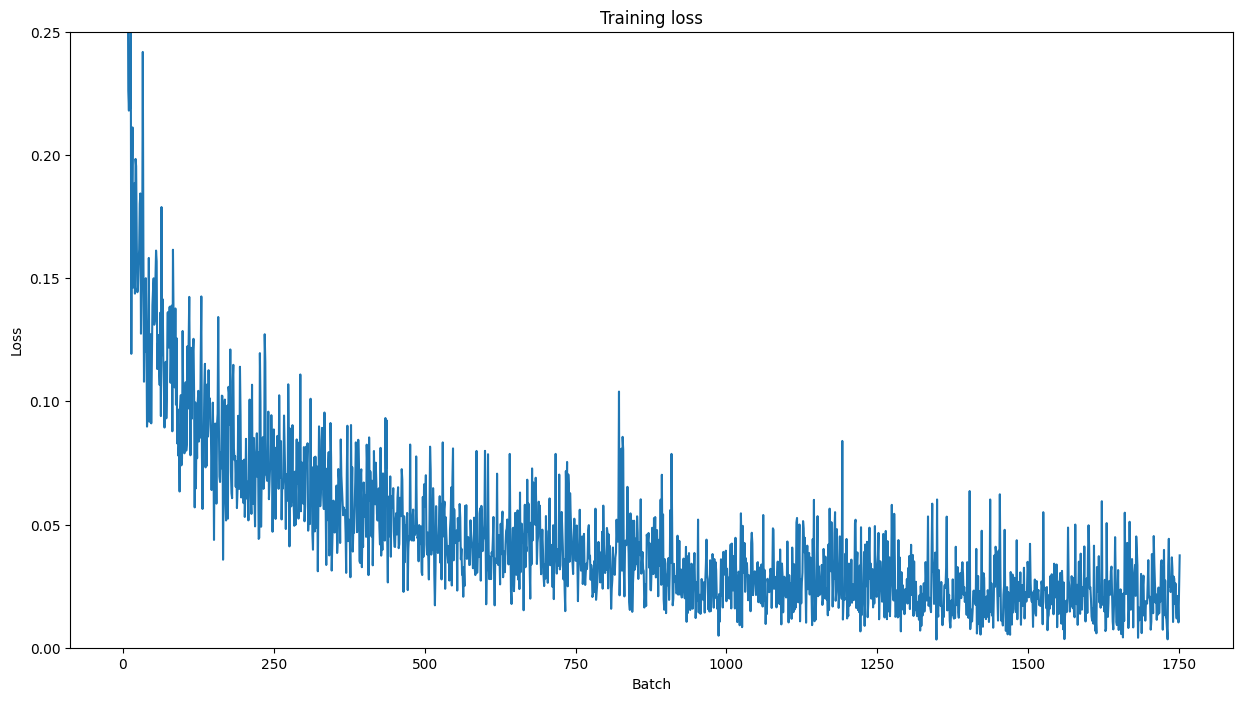

In [ ]:
import matplotlib.pyplot as plt
#สร้างกราฟเพื่อแสดงความสูญเสีย (loss) ในระหว่างการฝึกโมเดล โดยใช้ matplotlib
# Convert all tensors in the list to CPU-based NumPy arrays if necessary
train_loss_set_cpu = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in train_loss_set]

# Plotting
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.ylim(0,0.25)
plt.plot(train_loss_set_cpu)
plt.show()

In [ ]:
#Evaluate the model
#ทำการประเมินผลโมเดลที่ฝึกด้วย BERT สำหรับการจำแนกประเภทแท็ก (NER) ในชุดข้อมูลการตรวจสอบ (validation set)
model.eval() #เปลี่ยนโหมดของโมเดลเป็นการประเมินเพื่อปิดฟังก์ชัน dropout และ batch normalization
predictions = []
true_labels = []
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
for batch in valid_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                              attention_mask=b_input_mask, labels=b_labels)
        logits = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask)

    logits = logits.detach().cpu().numpy()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    label_ids = b_labels.to('cpu').numpy()
    true_labels.append(label_ids)
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy

    nb_eval_examples += b_input_ids.size(0)
    nb_eval_steps += 1

pred_tags = [[tags_vals[p_i] for p_i in p] for p in predictions]
valid_tags = [[tags_vals[l_ii] for l_ii in l_i] for l in true_labels for l_i in l ]
print("Validation loss: {}".format(eval_loss/nb_eval_steps))
print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))

Validation loss: 0.029177943032912233
Validation Accuracy: 0.9899621212121208
Validation F1-Score: 0.7750710166135836
